In [25]:
# !pip install transformers
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [26]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("/Dataset1-NamedEntityRecognition_train.json")

texts = [data[key]["text"] for key in data]
words = [sentence.split() for sentence in texts]
nested_labels = [data[key]["labels"] for key in data]

In [28]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)

# Vectorization of words
word_embeddings = []
for sentence in words:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings.append(sentence_embedding)

for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape 

(9435, 70, 100)

In [44]:
flat_labels = [label for sublist in nested_labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
labels_idx[0]

{'B_RESPONDENT', 'I_JUDGE', 'I_ORG', 'B_COURT', 'I_OTHER_PERSON', 'B_OTHER_PERSON', 'I_PROVISION', 'I_COURT', 'B_WITNESS', 'B_PROVISION', 'I_WITNESS', 'B_CASE_NUMBER', 'I_PETITIONER', 'I_CASE_NUMBER', 'B_GPE', 'I_RESPONDENT', 'I_DATE', 'I_STATUTE', 'B_PRECEDENT', 'I_GPE', 'O', 'B_ORG', 'B_STATUTE', 'I_PRECEDENT', 'B_DATE', 'B_JUDGE', 'B_PETITIONER'}


[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 2,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 2,
 2,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]

In [45]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(9435, 70, 27)

45/45 [==============================] - 0s 9ms/step
Epoch 1: Training Macro-F1-score: 0.1156402148971079, Validation Macro-F1-score: 0.11423121834910147
45/45 [==============================] - 1s 12ms/step
Epoch 2: Training Macro-F1-score: 0.18915839422418615, Validation Macro-F1-score: 0.18571972808704734
45/45 [==============================] - 1s 11ms/step
Epoch 3: Training Macro-F1-score: 0.21049085142174834, Validation Macro-F1-score: 0.20381949917976272
45/45 [==============================] - 1s 12ms/step
Epoch 4: Training Macro-F1-score: 0.21733833697265914, Validation Macro-F1-score: 0.21059659404736802
45/45 [==============================] - 0s 10ms/step
Epoch 5: Training Macro-F1-score: 0.2507386350508755, Validation Macro-F1-score: 0.239099641711581
45/45 [==============================] - 0s 10ms/step
Epoch 6: Training Macro-F1-score: 0.2852584157238096, Validation Macro-F1-score: 0.27289173246591314
45/45 [==============================] - 0s 10ms/step
Epoch 7: Trainin

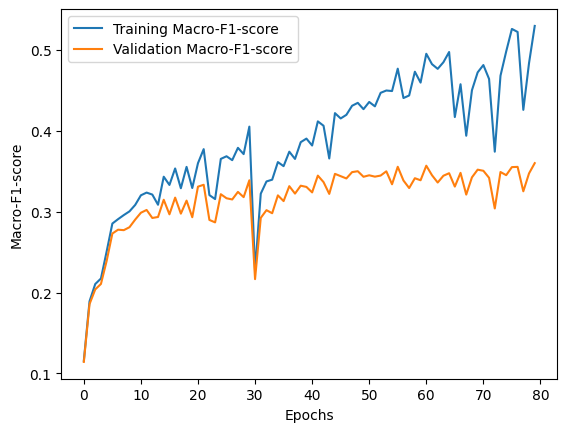

In [41]:
#SimpleRNN
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# 3. Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# 4. Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(80):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()

# plt.plot(train_f1_scores_per_label, label='Training Per label F1-score')
# plt.plot(val_f1_scores_per_label, label='Validation Per label F1-score')
# plt.xlabel('Epochs')
# plt.ylabel('F1-score')
# plt.legend()
# plt.show()


In [46]:
model.save('SimpleRNN-f1-Dataset1.keras')

In [ ]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val), batch_size=32, verbose=1)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Calculate and print F1-score
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)

# y_train_true = np.argmax(y_train, axis=-1)
# y_val_true = np.argmax(y_val, axis=-1)

# train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
# val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

# print("Training Macro-F1-score:", train_f1)
# print("Validation Macro-F1-score:", val_f1)


# GRU

Epoch 1/50
251/251 [==============================] - 20s 65ms/step - loss: 0.3546 - accuracy: 0.9101 - val_loss: 0.2898 - val_accuracy: 0.9213
Epoch 2/50
251/251 [==============================] - 13s 51ms/step - loss: 0.2598 - accuracy: 0.9288 - val_loss: 0.2719 - val_accuracy: 0.9255
Epoch 3/50
251/251 [==============================] - 18s 70ms/step - loss: 0.2437 - accuracy: 0.9318 - val_loss: 0.2646 - val_accuracy: 0.9264
Epoch 4/50
251/251 [==============================] - 17s 67ms/step - loss: 0.2339 - accuracy: 0.9341 - val_loss: 0.2635 - val_accuracy: 0.9281
Epoch 5/50
251/251 [==============================] - 20s 80ms/step - loss: 0.2286 - accuracy: 0.9349 - val_loss: 0.2573 - val_accuracy: 0.9280
Epoch 6/50
251/251 [==============================] - 17s 66ms/step - loss: 0.2226 - accuracy: 0.9363 - val_loss: 0.2602 - val_accuracy: 0.9277
Epoch 7/50
251/251 [==============================] - 16s 65ms/step - loss: 0.2203 - accuracy: 0.9367 - val_loss: 0.2637 - val_accuracy:

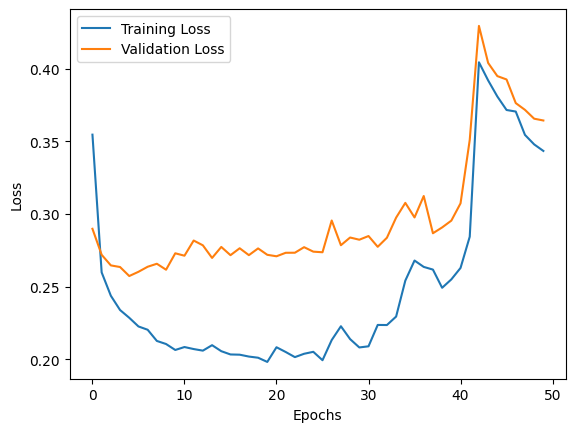

In [49]:
# GRU
## Increase accuracy
X_train_padded = word_embeddings  
y_train_padded = one_hot_labels           

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size = 32)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
model.save('GRU-Loss-Dataset1.keras')

In [ ]:
#GRU
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# 3. Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# 4. Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(80):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()

# plt.plot(train_f1_scores_per_label, label='Training Per label F1-score')
# plt.plot(val_f1_scores_per_label, label='Validation Per label F1-score')
# plt.xlabel('Epochs')
# plt.ylabel('F1-score')
# plt.legend()
# plt.show()

In [ ]:
model.save('GRU-f1-Dataset1.keras')

# LSTM

Epoch 1/20
81/81 [==============================] - 11s 80ms/step - loss: 0.3988 - accuracy: 0.3954 - val_loss: 0.3578 - val_accuracy: 0.3993
Epoch 2/20
81/81 [==============================] - 5s 65ms/step - loss: 0.3352 - accuracy: 0.4005 - val_loss: 0.3455 - val_accuracy: 0.3993
Epoch 3/20
81/81 [==============================] - 7s 91ms/step - loss: 0.3305 - accuracy: 0.4005 - val_loss: 0.3427 - val_accuracy: 0.3993
Epoch 4/20
81/81 [==============================] - 8s 99ms/step - loss: 0.3274 - accuracy: 0.4005 - val_loss: 0.3395 - val_accuracy: 0.3993
Epoch 5/20
81/81 [==============================] - 5s 62ms/step - loss: 0.3246 - accuracy: 0.4005 - val_loss: 0.3366 - val_accuracy: 0.3993
Epoch 6/20
81/81 [==============================] - 5s 60ms/step - loss: 0.3194 - accuracy: 0.4005 - val_loss: 0.3248 - val_accuracy: 0.3993
Epoch 7/20
81/81 [==============================] - 5s 65ms/step - loss: 0.3061 - accuracy: 0.4006 - val_loss: 0.3191 - val_accuracy: 0.4003
Epoch 8/20
8

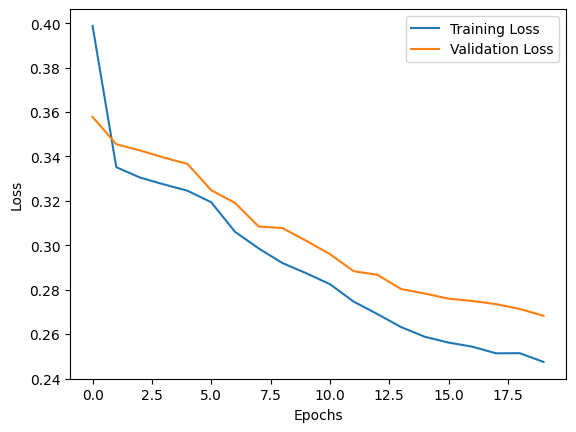

In [86]:
#LSTM
X_train_padded = word_embeddings  
y_train_padded = one_hot_labels           

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size = 32)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('LSTM-loss-Dataset1.keras')

45/45 [==============================] - 1s 21ms/step
Epoch 1: Training Macro-F1-score: 0.09102645921608692, Validation Macro-F1-score: 0.0896133102124809
45/45 [==============================] - 1s 21ms/step
Epoch 2: Training Macro-F1-score: 0.15006564538037057, Validation Macro-F1-score: 0.1495732486001542
45/45 [==============================] - 1s 26ms/step
Epoch 3: Training Macro-F1-score: 0.23004400241229894, Validation Macro-F1-score: 0.22338270092869306
45/45 [==============================] - 1s 23ms/step
Epoch 4: Training Macro-F1-score: 0.21098479582894708, Validation Macro-F1-score: 0.2070849336105288
45/45 [==============================] - 1s 25ms/step
Epoch 5: Training Macro-F1-score: 0.29001449776248706, Validation Macro-F1-score: 0.277992793132887
45/45 [==============================] - 2s 38ms/step
Epoch 6: Training Macro-F1-score: 0.27115233024448837, Validation Macro-F1-score: 0.2591542406888249
45/45 [==============================] - 2s 40ms/step
Epoch 7: Trainin

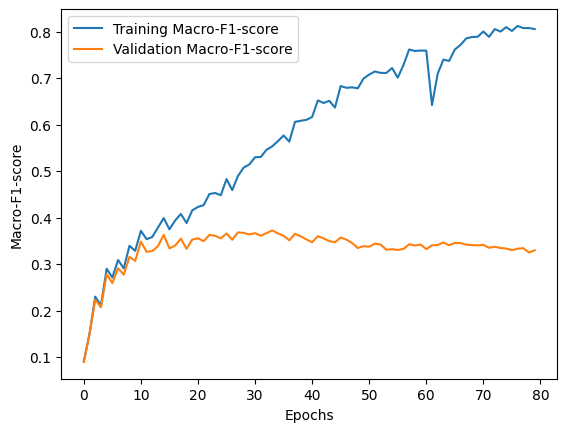

In [51]:
#LSTM
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# 3. Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# 4. Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(80):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()

# plt.plot(train_f1_scores_per_label, label='Training Per label F1-score')
# plt.plot(val_f1_scores_per_label, label='Validation Per label F1-score')
# plt.xlabel('Epochs')
# plt.ylabel('F1-score')
# plt.legend()
# plt.show()


In [ ]:
model.save('LSTM-f1-Dataset1.keras')

# Dataset2

In [52]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
data2 = load_data("Dataset2-AspectTermExtraction_train.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]

In [53]:
# find the maxlength of the sentence
max_length = max([len(i) for i in words2])
max_length

78

In [54]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)


In [55]:
# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

In [56]:
for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < max_length: #max length of sentence = 78
        while len(sentence) < max_length:
            sentence.append(np.zeros(100))     

# padding to convert into (905, 70, 100)  from (905, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
print(word_embeddings2.shape) 

(906, 78, 100)


In [61]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array

# Iterate over each sentence in one_hot_labels and pad to length 70
for i, sentence in enumerate(one_hot_labels):
    padded_sentence = np.pad(sentence, ((0, 78 - len(sentence)), (0, 0)), mode='constant', constant_values=1)
    labels_padded[i] = padded_sentence
labels_padded.shape

{'B', 'O', 'I'}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14632\549236327.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array


(906, 78, 3)

In [ ]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# # Split into training and validation sets (85-15 split)
# split = int(0.85 * len(X_train_padded))
# X_train, X_val = X_train_padded[:split], X_train_padded[split:]
# y_train, y_val = y_train_padded[:split], y_train_padded[split:]

from sklearn.model_selection import train_test_split

# Split into training and validation sets with stratified split
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train_padded, test_size=0.15, stratify=y_train_padded)

# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


5/5 [==============================] - 0s 9ms/step
Epoch 1: Training Macro-F1-score: 0.5159333798540614, Validation Macro-F1-score: 0.5201533765411691
5/5 [==============================] - 0s 9ms/step
Epoch 2: Training Macro-F1-score: 0.556078770255335, Validation Macro-F1-score: 0.5143777904276484
5/5 [==============================] - 0s 14ms/step
Epoch 3: Training Macro-F1-score: 0.6633035697816275, Validation Macro-F1-score: 0.6282495838458081
5/5 [==============================] - 0s 8ms/step
Epoch 4: Training Macro-F1-score: 0.6814611541492659, Validation Macro-F1-score: 0.6531170321282609
5/5 [==============================] - 0s 8ms/step
Epoch 5: Training Macro-F1-score: 0.6387221807011154, Validation Macro-F1-score: 0.6032378993520193
5/5 [==============================] - 0s 8ms/step
Epoch 6: Training Macro-F1-score: 0.7344567450366993, Validation Macro-F1-score: 0.6991676975949712
5/5 [==============================] - 0s 8ms/step
Epoch 7: Training Macro-F1-score: 0.7381453

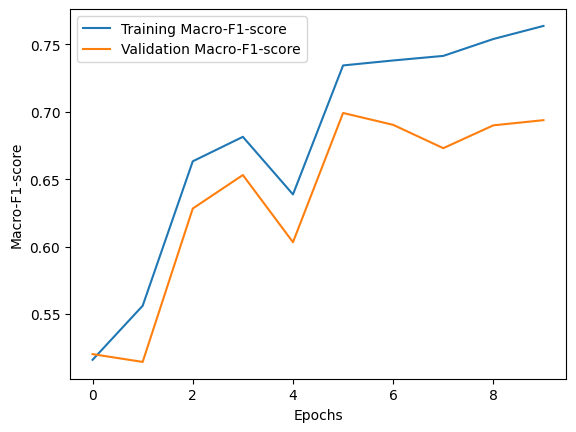

In [21]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()


# GRU

In [26]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)


Epoch 1/10
25/25 [==============================] - 5s 79ms/step - loss: 0.1265 - accuracy: 0.9525 - val_loss: 0.2025 - val_accuracy: 0.9718
Epoch 2/10
25/25 [==============================] - 1s 44ms/step - loss: 0.1492 - accuracy: 0.9706 - val_loss: 0.1267 - val_accuracy: 0.9736
Epoch 3/10
25/25 [==============================] - 1s 50ms/step - loss: 0.1059 - accuracy: 0.9737 - val_loss: 0.1022 - val_accuracy: 0.9736
Epoch 4/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0952 - accuracy: 0.9738 - val_loss: 0.0921 - val_accuracy: 0.9736
Epoch 5/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 0.0869 - val_accuracy: 0.9741
Epoch 6/10
25/25 [==============================] - 1s 44ms/step - loss: 0.0818 - accuracy: 0.9741 - val_loss: 0.0808 - val_accuracy: 0.9741
Epoch 7/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0770 - accuracy: 0.9743 - val_loss: 0.0767 - val_accuracy: 0.9743
Epoch 8/10
25

5/5 [==============================] - 0s 18ms/step
Epoch 1: Training Macro-F1-score: 0.3953444912593072, Validation Macro-F1-score: 0.3878131298816652
5/5 [==============================] - 0s 18ms/step
Epoch 2: Training Macro-F1-score: 0.40926845838863235, Validation Macro-F1-score: 0.39846681873379164
5/5 [==============================] - 0s 17ms/step
Epoch 3: Training Macro-F1-score: 0.45855178710174166, Validation Macro-F1-score: 0.4569518152632717
5/5 [==============================] - 0s 15ms/step
Epoch 4: Training Macro-F1-score: 0.48463094033646864, Validation Macro-F1-score: 0.4809693950152117
5/5 [==============================] - 0s 16ms/step
Epoch 5: Training Macro-F1-score: 0.5216605517040119, Validation Macro-F1-score: 0.528283562127093
5/5 [==============================] - 0s 15ms/step
Epoch 6: Training Macro-F1-score: 0.5437225389399886, Validation Macro-F1-score: 0.5262739171052524
5/5 [==============================] - 0s 15ms/step
Epoch 7: Training Macro-F1-score:

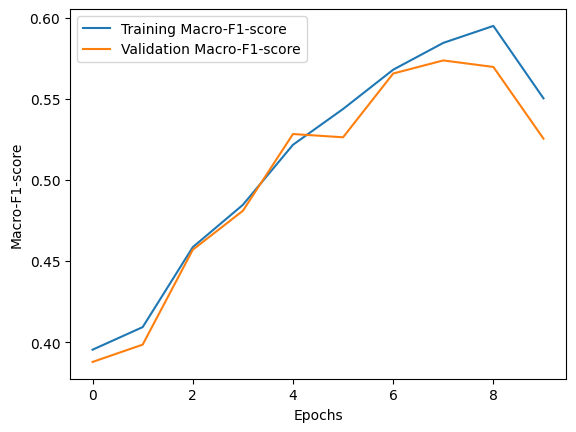

In [27]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()


# LSTM

In [28]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)




Epoch 1/10
25/25 [==============================] - 4s 72ms/step - loss: 0.1403 - accuracy: 0.9399 - val_loss: 0.1456 - val_accuracy: 0.9735
Epoch 2/10
25/25 [==============================] - 1s 47ms/step - loss: 0.1358 - accuracy: 0.9734 - val_loss: 0.1206 - val_accuracy: 0.9736
Epoch 3/10
25/25 [==============================] - 1s 58ms/step - loss: 0.1076 - accuracy: 0.9736 - val_loss: 0.0977 - val_accuracy: 0.9737
Epoch 4/10
25/25 [==============================] - 1s 57ms/step - loss: 0.0942 - accuracy: 0.9737 - val_loss: 0.0981 - val_accuracy: 0.9735
Epoch 5/10
25/25 [==============================] - 1s 56ms/step - loss: 0.0883 - accuracy: 0.9740 - val_loss: 0.0847 - val_accuracy: 0.9734
Epoch 6/10
25/25 [==============================] - 1s 55ms/step - loss: 0.0816 - accuracy: 0.9742 - val_loss: 0.0822 - val_accuracy: 0.9739
Epoch 7/10
25/25 [==============================] - 2s 65ms/step - loss: 0.0773 - accuracy: 0.9744 - val_loss: 0.0781 - val_accuracy: 0.9740
Epoch 8/10
25

5/5 [==============================] - 0s 19ms/step
Epoch 1: Training Macro-F1-score: 0.38705100102717643, Validation Macro-F1-score: 0.3751609634931529
5/5 [==============================] - 0s 19ms/step
Epoch 2: Training Macro-F1-score: 0.39986799068675466, Validation Macro-F1-score: 0.3859417572953508
5/5 [==============================] - 0s 19ms/step
Epoch 3: Training Macro-F1-score: 0.4037692077132981, Validation Macro-F1-score: 0.3913942698617688
5/5 [==============================] - 0s 21ms/step
Epoch 4: Training Macro-F1-score: 0.4077482483884147, Validation Macro-F1-score: 0.39378251589861274
5/5 [==============================] - 0s 21ms/step
Epoch 5: Training Macro-F1-score: 0.4264952968438307, Validation Macro-F1-score: 0.41749845379246137
5/5 [==============================] - 0s 20ms/step
Epoch 6: Training Macro-F1-score: 0.45357846475583097, Validation Macro-F1-score: 0.45539751158354513
5/5 [==============================] - 0s 21ms/step
Epoch 7: Training Macro-F1-sco

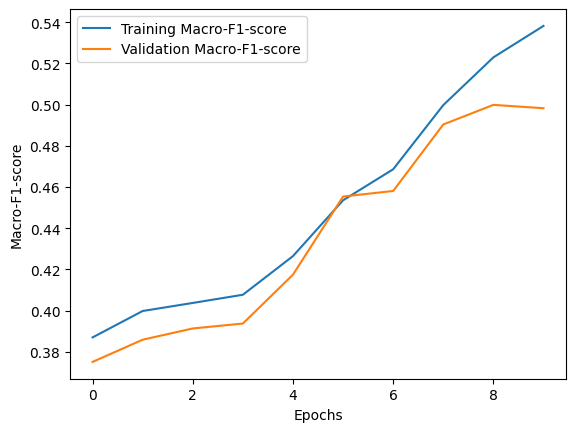

In [29]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()



## Test data

In [41]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data2 = load_data("Dataset2-AspectTermExtraction_test.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]


In [42]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)


In [44]:
# find the maxlength of the sentence
max_length = max([len(i) for i in words2])
max_length

71

In [45]:
# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

In [46]:
for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 70
        while len(sentence) < 78:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
word_embeddings2.shape 

(328, 78, 100)

In [47]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

{'O', 'I', 'B'}


In [48]:
labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array

# Iterate over each sentence in one_hot_labels and pad to length 70
for i, sentence in enumerate(one_hot_labels):
    padded_sentence = np.pad(sentence, ((0, 78 - len(sentence)), (0, 0)), mode='constant', constant_values=0)
    labels_padded[i] = padded_sentence
labels_padded.shape

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18108\1278505847.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array


(328, 78, 3)

In [49]:
X_test_padded = word_embeddings2
y_test_padded = labels_padded

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 0s 22ms/step - loss: 0.0617 - accuracy: 0.9769
Test Loss: 0.061659399420022964
Test Accuracy: 0.976860523223877
